# Clustering Crypto

In [69]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [70]:
import numpy as np

### additional imports

In [105]:
from pathlib import Path
# import holoviews.plotting.bokeh
# import holoviews as hv
# hv.extension('bokeh')
# from bokeh.plotting import show
import altair as alt
# from vega_datasets import data

### Fetching Cryptocurrency Data

In [72]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [73]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [74]:
# Alternatively, use the provided csv file:
file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
df = pd.read_csv(file_path)

In [75]:
df.head(5)

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [76]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_df = df.iloc[: , 1:]
crypto_df.head(5)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [77]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df [crypto_df['IsTrading'] == True]

In [78]:
# Keep only cryptocurrencies with a working algorithm

crypto_df.dropna(subset = ['Algorithm'], inplace = True)


In [79]:
# Remove the "IsTrading" column
crypto_df.drop('IsTrading', inplace = True, axis = 1)


In [80]:
crypto_df.isnull().sum()

CoinName             0
Algorithm            0
ProofType            0
TotalCoinsMined    459
TotalCoinSupply      0
dtype: int64

In [81]:
# Remove rows with at least 1 null value
crypto_df.dropna(inplace = True)
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
4,808,SHA-256,PoW/PoS,0.000000e+00,0
5,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
7,Bitcoin,SHA-256,PoW,1.792718e+07,21000000


In [82]:
crypto_df.dtypes
# df['a'] = pd.to_numeric(df['a'],errors = 'coerce')
crypto_df['TotalCoinSupply'] = pd.to_numeric(crypto_df['TotalCoinSupply'] ,errors = 'coerce')
crypto_df.dtypes

CoinName            object
Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply    float64
dtype: object

In [83]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df [crypto_df['TotalCoinSupply'] != 0]
crypto_df.head(5)

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
5,EliteCoin,X13,PoW/PoS,2.927942e+10,3.141593e+11
7,Bitcoin,SHA-256,PoW,1.792718e+07,2.100000e+07
9,Litecoin,Scrypt,PoW,6.303924e+07,8.400000e+07


In [84]:
# create dataframe to add later
coin_df = crypto_df.copy()

In [85]:
# Drop rows where there are 'N/A' text values
# aldready done..???

In [86]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coin_name = crypto_df.filter(['CoinName'], axis = 1)
# df_CoinName.column = ['CoinName']
coin_name.head()

,CoinName
0,42 Coin
2,404Coin
5,EliteCoin
7,Bitcoin
9,Litecoin


In [87]:
coin_name = crypto_df

In [88]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df.drop(['CoinName'], axis = 1, inplace = True)
crypto_df.head()


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
2,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
5,X13,PoW/PoS,2.927942e+10,3.141593e+11
7,SHA-256,PoW,1.792718e+07,2.100000e+07
9,Scrypt,PoW,6.303924e+07,8.400000e+07


In [89]:
# Create dummy variables for text features
# -- delete
# test = crypto_df.copy()
# # df.dtypes[df.dtypes == 'float64'].index.tolist()
# -- end delete
# # get a list of object types
obj_columns = crypto_df.dtypes[crypto_df.dtypes == 'object'].index.tolist()
# convert text columns to dummies
crypto_df = pd.get_dummies(crypto_df, columns= obj_columns)
crypto_df.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
0,4.199995e+01,4.200000e+01,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1.055185e+09,5.320000e+08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2.927942e+10,3.141593e+11,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1.792718e+07,2.100000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,6.303924e+07,8.400000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
# Standardize data
# test = crypto_df.copy()
cryto_scaled = StandardScaler().fit_transform(crypto_df)
print(cryto_scaled[:1])


[[-0.09782131 -0.03965512 -0.03965258 -0.03965258 -0.03965258 -0.05612135
  -0.07949286 -0.03965258 -0.03965258 -0.05612135 -0.03965258 -0.03965258
  -0.18913582 -0.05612135 -0.03965258 -0.03965258 -0.07949286 -0.03965258
  -0.08894601 -0.06878853 -0.03965258 -0.03965258 -0.17052613 -0.03965258
  -0.03965258 -0.13856406 -0.03965258 -0.03965258 -0.06878853 -0.03965258
  -0.03965258 -0.03965258 -0.03965258 -0.06878853 -0.03965258 -0.07949286
  -0.08894601 -0.07949286 -0.03965258 -0.03965258 -0.11971303 -0.13255899
  -0.14433757 -0.03965258 -0.05612135 -0.03965258 -0.06878853 -0.17052613
  -0.03965258 -0.03965258 -0.03965258 -0.05612135 -0.18004141 -0.33998043
  -0.03965258 -0.08894601 -0.06878853 -0.05612135 -0.03965258  1.42090019
  -0.06878853 -0.03965258 -0.03965258 -0.06878853 -0.06878853 -0.03965258
  -0.03965258 -0.03965258 -0.03965258 -0.03965258 -0.03965258 -0.03965258
  -0.4108617  -0.03965258 -0.18004141 -0.03965258 -0.09751265 -0.07949286
  -0.09751265 -0.03965258 -0.03965258 

### Reducing Dimensions Using PCA

In [91]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(cryto_scaled)

In [92]:
# Create a DataFrame with the principal components data
# df_iris_pca = pd.DataFrame(
#     data=iris_pca, columns=["principal component 1", "principal component 2"]
# )
# df_iris_pca.head()
pcs_df  = pd.DataFrame(
    data=crypto_pca, columns=["PC 1", "PC 2", "PC 3"], index = crypto_df.index
)
pcs_df.head()

,PC 1,PC 2,PC 3
0,-0.172443,-1.193404,-0.301775
2,-0.157874,-1.191477,-0.301987
5,0.416076,-1.896789,-0.369776
7,-0.248180,1.403862,0.105885
9,-0.321038,1.052202,0.017631


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [93]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
# df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

# show(hv.render(plot))

C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



:Curve   [k]   (inertia)

In [103]:
# altair plot
# import altair as alt
# import numpy as np
# import pandas as pd

# x = np.arange(100)
# source = pd.DataFrame({
#   'x': x,
#   'f(x)': np.sin(x / 5)
# })

alt.Chart(df_elbow).mark_line().encode(
    x='k',
    y='inertia'
)

alt.Chart(...)

Running K-Means with `k=<your best value for k here>`

In [94]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)
# Fit the model
model.fit(pcs_df)
# Predict clusters
predictions = model.predict(pcs_df)
# Create a new DataFrame including predicted clusters and cryptocurrencies features
pcs_df["Class"] = model.labels_
pcs_df.head()

,PC 1,PC 2,PC 3,Class
0,-0.172443,-1.193404,-0.301775,0
2,-0.157874,-1.191477,-0.301987,0
5,0.416076,-1.896789,-0.369776,0
7,-0.248180,1.403862,0.105885,1
9,-0.321038,1.052202,0.017631,1


In [95]:
# clustered_df = pd.concat ([coin_df, df_crypto_pca], join = 'outer')
# clustered_df.head()
clustered_df = coin_df.copy().dropna()

col_list = pcs_df.columns.tolist()
for columnName in col_list:
    clustered_df[columnName] = pcs_df[columnName]
clustered_df.head()


,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,Class
0,42 Coin,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01,-0.172443,-1.193404,-0.301775,0
2,404Coin,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08,-0.157874,-1.191477,-0.301987,0
5,EliteCoin,X13,PoW/PoS,2.927942e+10,3.141593e+11,0.416076,-1.896789,-0.369776,0
7,Bitcoin,SHA-256,PoW,1.792718e+07,2.100000e+07,-0.248180,1.403862,0.105885,1
9,Litecoin,Scrypt,PoW,6.303924e+07,8.400000e+07,-0.321038,1.052202,0.017631,1


### Visualizing Results

#### 3D-Scatter with Clusters

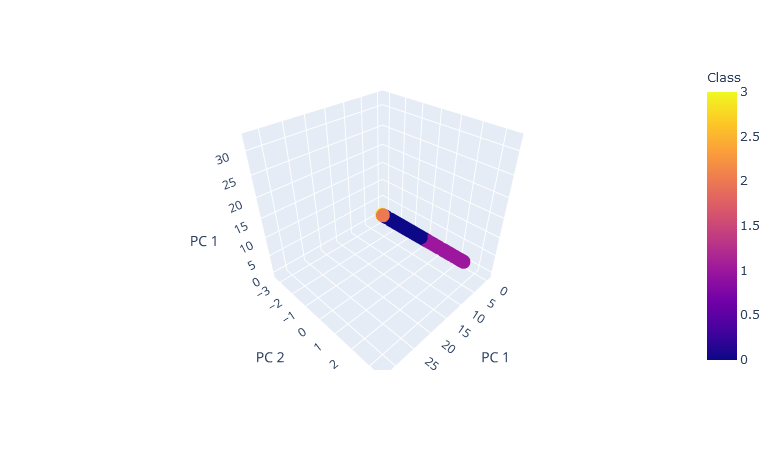

In [96]:
# Create a 3D-Scatter with the PCA data and the clusters

# fig.update_layout(legend=dict(x=0, y=1))
# fig.show()
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 1",
    color="Class",
#     symbol="class",
    hover_name="CoinName",
    hover_data=["Algorithm"],
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [110]:
# delete
# transform objects to strings.
# clustered_df.dtypes

CoinName            object
Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply    float64
PC 1               float64
PC 2               float64
PC 3               float64
Class                int32
dtype: object

In [111]:
# delete
# df['column'] = df['column'].astype('str') 
# change objects columns to string
# make a copy
# alt_clust_df = clustered_df.copy()
# change objects to sting (assuming all objects are strings)

# sample code
# all_btc_tokens = []
# for index, row in bitcoin_df.iterrows():
#     all_btc_tokens.extend(row['tokens'])

In [118]:
# alair
# import altair as alt
# from vega_datasets import data

# source = data.cars()

alt.Chart(clustered_df).mark_circle(size=60).encode(
    x='PC 1',
    y='PC 2',
    color='Algorithm',
    tooltip=["CoinName", "Algorithm", "TotalCoinsMined", "TotalCoinSupply"]
).interactive()

alt.Chart(...)

#### Table of Tradable Cryptocurrencies

In [97]:
# Table with tradable cryptos
# df.hvplot.table(columns=['origin', 'name', 'yr'], sortable=True, selectable=True)
col_list = ["CoinName", "Algorithm", "ProofType", "TotalCoinSupply", "TotalCoinsMined", "Class"]
clustered_df.hvplot.table(columns =col_list)

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

In [121]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df)
    
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(clustered_df)
print(clustered_df.to_string())

                              CoinName               Algorithm             ProofType  TotalCoinsMined  TotalCoinSupply       PC 1      PC 2       PC 3  Class
0                              42 Coin                  Scrypt               PoW/PoS     4.199995e+01     4.200000e+01  -0.172443 -1.193404  -0.301775      0
2                              404Coin                  Scrypt               PoW/PoS     1.055185e+09     5.320000e+08  -0.157874 -1.191477  -0.301987      0
5                            EliteCoin                     X13               PoW/PoS     2.927942e+10     3.141593e+11   0.416076 -1.896789  -0.369776      0
7                              Bitcoin                 SHA-256                   PoW     1.792718e+07     2.100000e+07  -0.248180  1.403862   0.105885      1
9                             Litecoin                  Scrypt                   PoW     6.303924e+07     8.400000e+07  -0.321038  1.052202   0.017631      1
10                                Dash              

In [98]:
# Print the total number of tradable cryptocurrencies
print (f'Total Tradable Currencies: {clustered_df["TotalCoinSupply"].sum()}')

Total Tradable Currencies: 9.223962144580946e+16


#### Scatter Plot with Tradable Cryptocurrencies

In [99]:
# Scale data to create the scatter plot
# select columns to be charted
cluster_for_chart = clustered_df.filter(['TotalCoinsMined',"TotalCoinSupply" ], axis=1)
# scale them to data 
culster_scaled_np = StandardScaler().fit_transform(cluster_for_chart)
# transform to np array to dataframe
cluster_scaled_df = pd.DataFrame(culster_scaled_np, columns = ['TotalCoinsMined',"TotalCoinSupply"])
cluster_scaled_df.head(1)

,TotalCoinsMined,TotalCoinSupply
0,-0.097821,-0.039655


In [100]:
type(culster_scaled)

numpy.ndarray

In [101]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
cluster_scaled_df.hvplot.scatter(
        x="TotalCoinsMined",
        y="TotalCoinSupply",
        hover_cols=["CoinName"]
        )

:Scatter   [TotalCoinsMined]   (TotalCoinSupply)

In [153]:
alt.Chart(df_temp).mark_circle(size=60).encode(
    x="TotalCoinsMined",
    y='TotalCoinSupply',
#     color='indx'
#     tooltip=['indx']
).interactive()

alt.Chart(...)